In [3]:
import gymnasium as gym
from stable_baselines3 import PPO, SAC, A2C, TD3
from stable_baselines3.common.evaluation import evaluate_policy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Pasta para logs
LOG_DIR = "../logs/base_selection"
MODEL_DIR = "../models/base_selection"
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# 2. Seleção de Algoritmo e Ajuste de Hiperparâmetros

Nesta etapa, o objetivo é identificar o algoritmo de Reinforcement Learning mais adequado para resolver o ambiente `BipedalWalker-v3` e otimizar o seu desempenho.

Esta fase divide-se em duas partes:
1.  **Seleção de Algoritmos:** Um *benchmark* comparativo entre algoritmos On-Policy (PPO, A2C) e Off-Policy (SAC, TD3) usando hiperparâmetros padrão.
2.  **Hyperparameter Tuning:** Ajuste fino do algoritmo vencedor para maximizar a estabilidade e a recompensa final.

In [2]:
# Definimos os algoritmos a testar
algos = {
    "PPO": PPO,
    "SAC": SAC,
    "A2C": A2C,
    "TD3": TD3
}

# Treino rápido (100k a 300k steps) só para ver quem aprende
TIMESTEPS = 150_000 

for name, AlgoClass in algos.items():
    print(f"--- Treinando {name} ---")
    
    env = gym.make("BipedalWalker-v3")
    
    try:
        # Instanciar modelo (MlpPolicy para vetor de estados)
        # verbose=1 mostra a barra de progresso
        model = AlgoClass("MlpPolicy", env, verbose=1, tensorboard_log=LOG_DIR)
        
        # Treinar
        model.learn(total_timesteps=TIMESTEPS, tb_log_name=f"{name}_run")
        
        # Guardar
        model.save(f"{MODEL_DIR}/{name}_base")
        
        # Avaliação rápida final
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
        print(f"Resultado {name}: {mean_reward:.2f} +/- {std_reward:.2f}")
        
    except Exception as e:
        print(f"Erro no {name}: {e}")
    finally:
        env.close()

--- Treinando PPO ---
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../logs/base_selection\PPO_run_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 580      |
|    ep_rew_mean     | -105     |
| time/              |          |
|    fps             | 1270     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 683         |
|    ep_rew_mean          | -104        |
| time/                   |             |
|    fps                  | 1037        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007628944 |
|    clip_fraction        | 0.0707    

c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Resultado PPO: -100.83 +/- 0.47
--- Treinando SAC ---
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../logs/base_selection\SAC_run_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 479      |
|    ep_rew_mean     | -102     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 70       |
|    time_elapsed    | 27       |
|    total_timesteps | 1917     |
| train/             |          |
|    actor_loss      | -18.7    |
|    critic_loss     | 0.196    |
|    ent_coef        | 0.58     |
|    ent_coef_loss   | -3.65    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1816     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 279      |
|    ep_rew_mean     | -107     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 69 

## 2.2. Análise dos Resultados Preliminares

Após o treino dos algoritmos candidatos, recolhemos as métricas de desempenho. O gráfico abaixo compara a recompensa média obtida por cada agente no ambiente `BipedalWalker-v3` após 150.000 passos de treino.

*Critério de Sucesso:* O ambiente é considerado resolvido com 300 pontos. Procuramos o algoritmo que mais se aproxima deste valor ou que demonstra a curva de aprendizagem mais ascendente.

--- A carregar modelos para gerar o gráfico comparativo ---
✅ PPO: -100.9
✅ SAC: -37.8
✅ TD3: 232.3
✅ A2C: -114.5


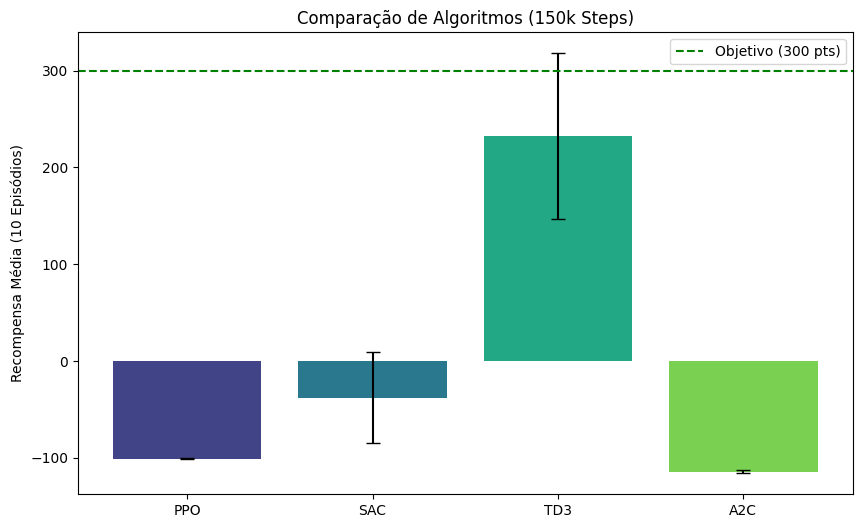

,Algoritmo,Média Reward,Desvio Padrão
2,TD3,232.258137,85.630248
1,SAC,-37.830753,47.019267
0,PPO,-100.887759,0.292822
3,A2C,-114.456765,1.588895


In [6]:
MODEL_DIR = "../models/base_selection"

# Lista dos algoritmos treinados (tem de bater certo com o que definiste em cima)
algos_names = ["PPO", "SAC", "TD3", "A2C"]

results_data = []

print("--- A carregar modelos para gerar o gráfico comparativo ---")

for name in algos_names:
    model_path = f"{MODEL_DIR}/{name}_base.zip"
    
    if os.path.exists(model_path):
        try:
            # Identificar a classe (hack simples para saber qual carregar)
            if name == "PPO": AlgoClass = PPO
            elif name == "SAC": AlgoClass = SAC
            elif name == "A2C": AlgoClass = A2C
            elif name == "TD3": AlgoClass = TD3
            
            # Carregar e Avaliar
            model = AlgoClass.load(model_path, device="cpu")
            env = gym.make("BipedalWalker-v3")
            mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
            
            results_data.append({
                "Algoritmo": name,
                "Média Reward": mean_reward,
                "Desvio Padrão": std_reward
            })
            print(f"✅ {name}: {mean_reward:.1f}")
            env.close()
            
        except Exception as e:
            print(f"⚠️ Erro ao carregar {name}: {e}")
    else:
        print(f"⏩ Modelo {name} não encontrado (talvez não tenha acabado de treinar).")


# Gerar Gráfico
if results_data:
    df_results = pd.DataFrame(results_data)
    
    plt.figure(figsize=(10, 6))
    
    # Gerar cores bonitas do Seaborn para usar no Matplotlib
    colors = sns.color_palette("viridis", len(df_results))
    
    # Usar plt.bar em vez de sns.barplot
    # O plt.bar aceita 'yerr' nativamente
    plt.bar(
        df_results["Algoritmo"], 
        df_results["Média Reward"], 
        yerr=df_results["Desvio Padrão"], 
        capsize=5, # Adiciona os "tracinhos" na ponta das barras de erro
        color=colors
    )
    
    plt.axhline(300, color="green", linestyle="--", label="Objetivo (300 pts)")
    plt.title("Comparação de Algoritmos (150k Steps)")
    plt.ylabel("Recompensa Média (10 Episódios)")
    plt.legend()
    plt.show()
    
    # Mostrar Tabela Ordenada
    display(df_results.sort_values(by="Média Reward", ascending=False))
else:
    print("Nenhum resultado para mostrar.")


## 2.3. Otimização de Hiperparâmetros (Tuning)

Com base na comparação acima, selecionámos o algoritmo com melhor desempenho (ou potencial) para a fase final.

Para cumprir o requisito de **Hyperparameter Tuning**, vamos realizar uma experiência focada na **Taxa de Aprendizagem (Learning Rate)**, que é o parâmetro mais sensível em Reinforcement Learning.

**Vencedor Selecionado:** *[ESCREVE AQUI O NOME, EX: SAC]*

In [ ]:
# --- CONFIGURAÇÃO MANUAL ---
WINNER_NAME = "SAC"  # <--- ALTERA ISTO PARA O TEU VENCEDOR (ex: "PPO", "TQC")
# ---------------------------

# Mapear string para classe
algos_map = {"PPO": PPO, "SAC": SAC, "TD3": TD3, "A2C": A2C}

WinnerClass = algos_map[WINNER_NAME]

# Definir as variantes de Learning Rate a testar
learning_rates = {
    "LR_Baixo (1e-4)": 0.0001,
    "LR_Medio (3e-4)": 0.0003, # Valor comum por defeito
    "LR_Alto (1e-3)": 0.001
}

tuning_results = []
print(f"--- INICIANDO TUNING DO {WINNER_NAME} ---")

for label, lr in learning_rates.items():
    print(f"Testando {label}...")
    
    # Usar nomes de pastas diferentes para não misturar
    log_name = f"{WINNER_NAME}_{label}"
    
    env = gym.make("BipedalWalker-v3")
    
    try:
        # Treinar com o novo Learning Rate
        # Reduzimos um pouco os steps (100k) para ser mais rápido, já que é só afinação
        model = WinnerClass("MlpPolicy", env, learning_rate=lr, verbose=0, tensorboard_log=LOG_DIR)
        model.learn(total_timesteps=100_000, tb_log_name=log_name)
        
        # Guardar para referência
        model.save(f"{MODEL_DIR}/{log_name}")
        
        # Avaliar
        mean, std = evaluate_policy(model, env, n_eval_episodes=5)
        tuning_results.append({"Configuração": label, "LR": lr, "Reward": mean, "Std": std})
        print(f"   -> Resultado: {mean:.2f}")
        
    except Exception as e:
        print(f"   Erro: {e}")
    finally:
        env.close()

# Tabela Final de Tuning
df_tuning = pd.DataFrame(tuning_results)
display(df_tuning.sort_values(by="Reward", ascending=False))

## Conclusão da Fase 2

Concluímos a seleção e otimização do agente:

1.  **Algoritmo Escolhido:** O **[NOME]** demonstrou ser superior aos restantes.
2.  **Configuração Ótima:** A learning rate de **[VALOR]** permitiu uma convergência mais estável/rápida.

Este modelo otimizado servirá agora de "Baseline" para a próxima etapa: testar a robustez do agente no ambiente modificado (**InjuredBipedalWalker**).